In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

import easyocr

In [3]:
class CFG:
    
    #paths
    out_folder = f'/kaggle/working'
    class_name = ['car_plate']
    video_test_path = 'https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

    weights = 'vehicule_model.pt'
    exp_name = 'car_plate_detection'
    img_size = (240,400)
    vehicles_class = [2, 3, 5, 7] 
    
    #Yolo train parameters
    epochs = 50
    batch_size = 16
    optimizer = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    lr = 1e-3
    lr_factor = 0.01 #lo*lr_f
    weight_decay = 5e-4
    dropout = 0.0
    patience = int(0.7*epochs)
    profile = False
    label_smoothing = 0.0 
    
    #models Confidance
    vehicle_conf = 0.5
    plate_conf = 0.3
    ocr_conf = 0.1
    
    seed = 42

In [4]:
def display_image(image, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    fig = plt.figure(figsize = figsize)
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.shape[-1] == 3:
            image = image[..., ::-1]  # BGR to RGB
            img = Image.fromarray(image)
            plt.imshow(img)
        else:
            img = np.copy(image)
            plt.imshow(img,cmap = 'gray') 
        
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

def extract_ocr(roi_img, reader):

    ocr_result = reader.readtext(np.asarray(roi_img), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_plate = ''
    if len(ocr_result) > 0:
        
        for item in ocr_result:
            text, conf = item[-2], item[-1]
            text = text if conf > CFG.ocr_conf else ''
            text_plate+=text
    else:
        text_plate, conf = 'unreco_plate', 0
    
    text_plate = text_plate.lower()


    return text_plate,conf

def extract_roi(image, bounding_box):
    """
    Crop the input image based on the provided bounding box coordinates.

    Args:
        image (numpy.ndarray): The input image.
        bounding_box (tuple): A tuple containing (x_min, y_min, x_max, y_max)
            coordinates of the bounding box.

    Returns:
        numpy.ndarray: The cropped image.
    """
    x_min, x_max, y_min, y_max = bounding_box
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image


def inference_inside_roi(df_coords, img, model, device ,display = False):

    bboxs = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values
    
   
    df_plate = pd.DataFrame()
    for i,bbox in enumerate(bboxs):
  
        vehicle_img = extract_roi(img, bbox)
        
        results = model.predict(vehicle_img, 
                        conf = CFG.plate_conf, 
                        classes =[0], 
                        device = device, 
                        verbose = False)

        position_frame = pd.DataFrame(results[0].cpu().numpy().boxes.data, 
                                       columns = ['xmin', 'ymin', 'xmax', 
                                                  'ymax', 'conf', 'class'])

        position_frame['class'] = position_frame['class'].replace({0:'car_plate'})
        position_frame['plate_number'] = 'unreco_plate'
 
        #Filter cases with more them one plate per vehicle
        position_frame = position_frame.loc[position_frame['conf'] == position_frame['conf'].max(),:]
        
        #adjust bbox of plate for complete image
        position_frame['xmin']+=bbox[0]
        position_frame['xmax']+=bbox[0]
        position_frame['ymin']+=bbox[2]
        position_frame['ymax']+=bbox[2]
        
        if display:
            display_image(vehicle_img, hide_axis = True, figsize =(10,10), title='Vehicle ROI Image')
        
        if len(position_frame) > 0:
            
            plate_bbox = position_frame[['xmin','xmax','ymin','ymax']].values.squeeze().astype(int)
            plate_img = extract_roi(img, plate_bbox)
            text_plate, conf_ocr = extract_ocr(plate_img, reader)
            position_frame['plate_number'] = text_plate
            
            if display:
                display_image(plate_img, hide_axis = True, figsize =(10,10), title=f'ROI Plate | Nº: {text_plate}')
            

        
            
        position_frame = position_frame[['xmin', 'ymin', 'xmax','ymax' ,'conf', 'class', 'plate_number']]
                                                  
        
        df_plate = pd.concat([df_plate, position_frame], axis = 0)
        
    return img, df_plate

def drawBBox(df_coords, img, title = '' ,thickness=1):

    cords = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values
   
    for i,detection in enumerate(cords): 


        start_point = (detection[0], detection[-1]) # x_min, y_max
        end_point = (detection[1], detection[2]) # x_max, y_min
        class_detected = classes[i]
    
        
        if class_detected == 'car_plate':
            number_plate = df_coords['plate_number'].values[i]
            cv2.rectangle(img, start_point, end_point, (0,0,190), thickness)
            cv2.putText(img=img, text=f'{class_detected} ', 
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            cv2.putText(img=img, text=f'{number_plate}', 
                org= (detection[0]-10, detection[-1]+30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        else:
            cv2.rectangle(img, start_point, end_point, (255,0,0), thickness)
        
            cv2.putText(img=img, text=f'{class_detected}', 
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)
        
    return img

In [5]:
test_device = 'cuda' if ultralytics.checks() else 'cpu'
plate_model = YOLO('plate_model.pt')
vehicle_model = YOLO(CFG.weights)
reader = easyocr.Reader(['en'],  gpu=True if test_device != 'cpu' else False)

plate_model.to(test_device)
vehicle_model.to(test_device)

print('\nModels Info')
print('Plate Model: ', plate_model.device, 'Vehicle Model: ', vehicle_model.device)

Ultralytics 8.4.14 🚀 Python-3.10.19 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Setup complete ✅ (12 CPUs, 7.6 GB RAM, 140.7/1006.9 GB disk)


Using CPU. Note: This module is much faster with a GPU.



Models Info
Plate Model:  cpu Vehicle Model:  cpu


In [6]:
dict_all_classes = vehicle_model.model.names
dict_classes = {}
for id_class in CFG.vehicles_class:
    dict_classes[id_class] = dict_all_classes[id_class]

dict_classes

{2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}

In [7]:
def run_pipeline(path, display=False):
    
    '''
    1. Detect vehicles from a input image. 
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from croped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from croped plate detections. 
    '''

    image = cv2.imread(path)

    if display:
        display_image(image, 
                      hide_axis =True, 
                      figsize = (10,10), 
                      title='Input Image')

    # 1. Detect vehicles from a input image.
    vehicle_results = vehicle_model.predict(
                            image, 
                            conf =CFG.vehicle_conf, 
                            classes = CFG.vehicles_class, 
                            device = test_device, 
                            verbose = False,
                            )
    
    df_vehicles = pd.DataFrame(
        vehicle_results[0].cpu().numpy().boxes.data, 
        columns = ['xmin', 'ymin', 'xmax', 'ymax','conf', 'class'])
    
    if not df_vehicles.empty:
        df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)
    else:
        print("Aucun véhicule détecté")

    best_text = ""
    best_conf = -1

    # 2, 3, 4, 5. Crop the ROIs with BBOX of vehicles detections, Detect plates from croped vehicle images
    if not df_vehicles.empty:
        # Détection plaques dans ROI véhicules
        image, df_plates = inference_inside_roi(
                                df_vehicles, 
                                image,
                                plate_model, 
                                test_device,
                                display=display
                            )
    else:
        # FALLBACK : détection plaque sur image complète
        print("Fallback : détection plaque sur image complète")

        plate_results = plate_model.predict(
                            image,
                            conf=CFG.plate_conf,
                            device=test_device,
                            verbose=False
                        )

        df_plates = pd.DataFrame(
            plate_results[0].cpu().numpy().boxes.data,
            columns=['xmin', 'ymin', 'xmax', 'ymax','conf', 'class']
        )

        if not df_plates.empty:
            df_plates['class'] = "plate"

            for i, row in df_plates.iterrows():
                x1, y1, x2, y2 = map(int, row[['xmin','ymin','xmax','ymax']])
                crop_plate = image[y1:y2, x1:x2]

                ocr_result = extract_ocr(crop_plate, reader)

                # Cas où extract_ocr retourne une liste de tuples
                if isinstance(ocr_result, list):
                    for item in ocr_result:
                        if isinstance(item, tuple) and len(item) >= 2:
                            text, conf = item[0], item[1]
                            if conf > best_conf:
                                best_conf = conf
                                best_text = text

                # Cas où extract_ocr retourne un tuple (text, confidence)
                elif isinstance(ocr_result, tuple) and len(ocr_result) >= 2:
                    best_text = ocr_result[0]
                    best_conf = ocr_result[1]

                # Cas où extract_ocr retourne directement une string
                else:
                    best_text = str(ocr_result)

                df_plates.at[i, 'plate_number'] = str(best_text).upper()
                df_plates.at[i, 'ocr_conf'] = best_conf

        else:
            df_plates = pd.DataFrame()

    if best_text and best_conf != -1:
        plate_number = best_text.upper()
    else:
        plate_number = df_plates['plate_number'].iloc[0]
        
    return plate_number, image

In [8]:
test_image = 'images/peugeot.jpg'

Type:  <class 'PIL.Image.Image'> 

Shape:  (720, 1280, 3) 



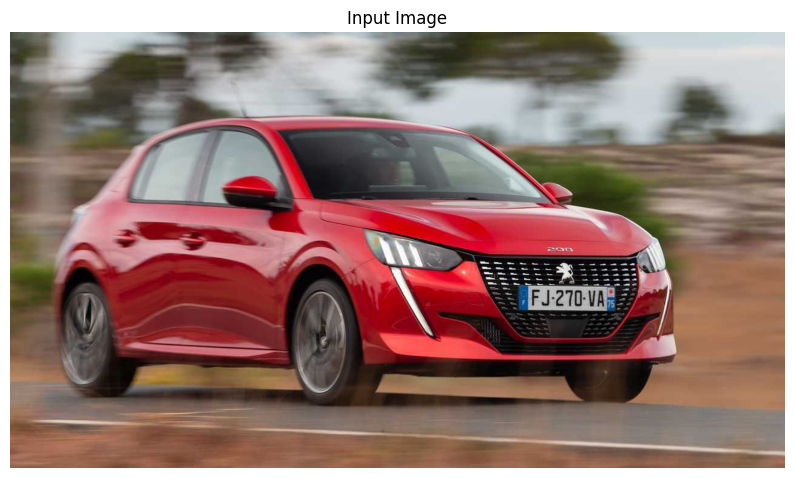

Type:  <class 'PIL.Image.Image'> 

Shape:  (483, 1026, 3) 



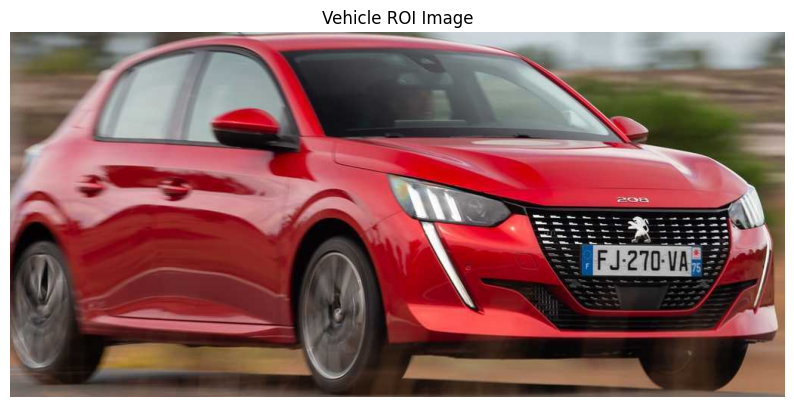

Type:  <class 'PIL.Image.Image'> 

Shape:  (39, 151, 3) 



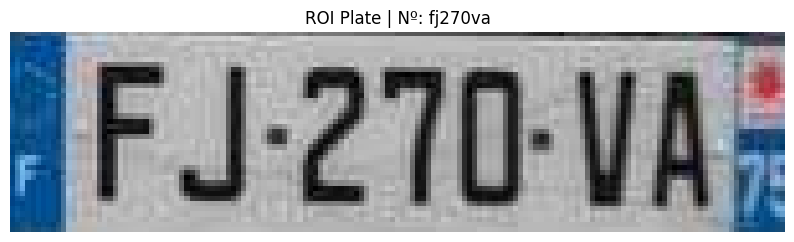

Plate number: fj270va


In [9]:
plate_number, out_image = run_pipeline(path = test_image, display=True)
print("Plate number:", plate_number)